In [1]:
import pandas as pd
import numpy as np
import scipy
from pykalman.pykalman import *
import control
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set(style='white', font_scale=1.5)
import copy

# Import custom modules
import prep_emotioncon 
import emotioncon_modelling
import emotioncon_stats
import auxiliary

In [2]:
# Create instances of the Modelling, Statistics, PrepEmotioncon and PrepData classes
emo = emotioncon_modelling.Modelling()
emostats = emotioncon_stats.Statistics()
prep = prep_emotioncon.PrepEmotioncon()
aux = auxiliary.Auxiliary()

mood_categories = ['disgusted', 'amused', 'calm', 'anxious', 'sad'] # Define the mood categories as a list
filepath = '../' # Specify the file path
debug = False  # Flag to indicate whether to save file and figures or not

# Load data from a numpy file
data = np.load(filepath + 'results/fit_experiment.npy', allow_pickle=True)

# Process the loaded data into a DataFrame, mood ratings, and other related variables
df, mood_ratings, foo = prep.create_df_from_dict(data)

# Create inputs based on videos shown during experiment
inp = emo.input_from_videos('../experiment/public/prep/videosForExperiment.csv')

# Calculate the number of subjects based on the length of the loaded data
Nsj = len(data)
print('N = ' + str(Nsj))

N = 108


In [3]:
# Function to simulate individual data from fitted Kalman filter
def simulate_data(data, kf_before, kf_after, inp, mood_ratings):
    # Create a new array to store the simulated mood ratings
    mood_ratings_split = np.empty((int(np.shape(mood_ratings)[0]/2), np.shape(mood_ratings)[1], np.shape(mood_ratings)[2], 2))
    T = np.shape(data[0]['ratings'])[1]
    
    # Simulate for both before and after intervention
    for t in range(2):
        # Split the input data based on intervention time
        inp_split = inp[t*int(T/2):t*int(T/2) + int(T/2),:]
        
        # Simulate for each subject
        for sj in range(Nsj):
            # Copy the Kalman filter results for the specific intervention time
            if (t == 0):
                subject_kf = copy.copy(data[sj]['results_split'][kf_before])
            elif (t == 1):
                subject_kf = copy.copy(data[sj]['results_split'][kf_after])
            
            # Sample from the Kalman filter to get simulated mood ratings
            foo, x = subject_kf.sample(int(T/2), initial_state=data[sj]['ratings'][:, t*int(T/2)], control_inputs=inp_split)
            mood_ratings_split[:, :, sj, t] = x
            
    return mood_ratings_split

def plot_simulated_data_and_stats(mood_ratings_split, df, mood_categories):
    # Define labels for plotting
    label = ['simulated mean', 'simulated variance']
    
    # Create pairs for statistical comparisons
    pairs = []
    for t in range(2):
        for i in mood_categories:
            pairs.append([(i, 0+t), (i, 2+t)])
            pairs.append([(i, t+(t*1)), (i, t+(t*1)+1)])

    # Create an empty DataFrame to store statistical results
    df_stats_both = pd.DataFrame()
    
    # Loop through simulated mean and variance ratings
    for j, i in enumerate([np.nanmean(mood_ratings_split, axis=0), np.nanvar(mood_ratings_split, axis=0)]):
        # Calculate group differences and perform statistical tests
        df_stats, pvalues, tvalues = emostats.stats_group_difference(i, df)
        
        # Create DataFrame for plotting
        df_plot = emostats.make_df(i, df, mood_categories)
        
        # Create the plot
        fig, ax = plt.subplots(figsize=(20, 8))
        fig, ax = emostats.plot_group_difference(df=df_plot, data_labels=mood_categories, \
                                                 data_name=label[j] + ' ratings', pairs=pairs, fig=fig, ax=ax, \
                                                 ms=False)
        
        # Set ylabel for the plot
        ax.set(ylabel=label[j] + ' ratings')
        
        # Concatenate the statistical results to the DataFrame for both mean and variance
        df_stats_both = pd.concat((df_stats_both, df_stats), axis=1)

    # Display the statistical results
    display(df_stats_both)


,T2,Fstats,pvalue,T2,Fstats,pvalue
before intervention,4.28,0.82,0.539,16.91,3.23,0.010
after intervention,12.16,2.33,0.049,17.87,3.42,0.007
change (after - before),32.94,6.30,< 0.001,3.18,0.61,0.695


,T2,Fstats,pvalue,T2,Fstats,pvalue
before intervention,7.95,1.53,0.189,13.36,2.56,0.032
after intervention,15.14,2.91,0.017,20.55,3.95,0.003
change (after - before),32.09,6.16,< 0.001,14.72,2.83,0.020


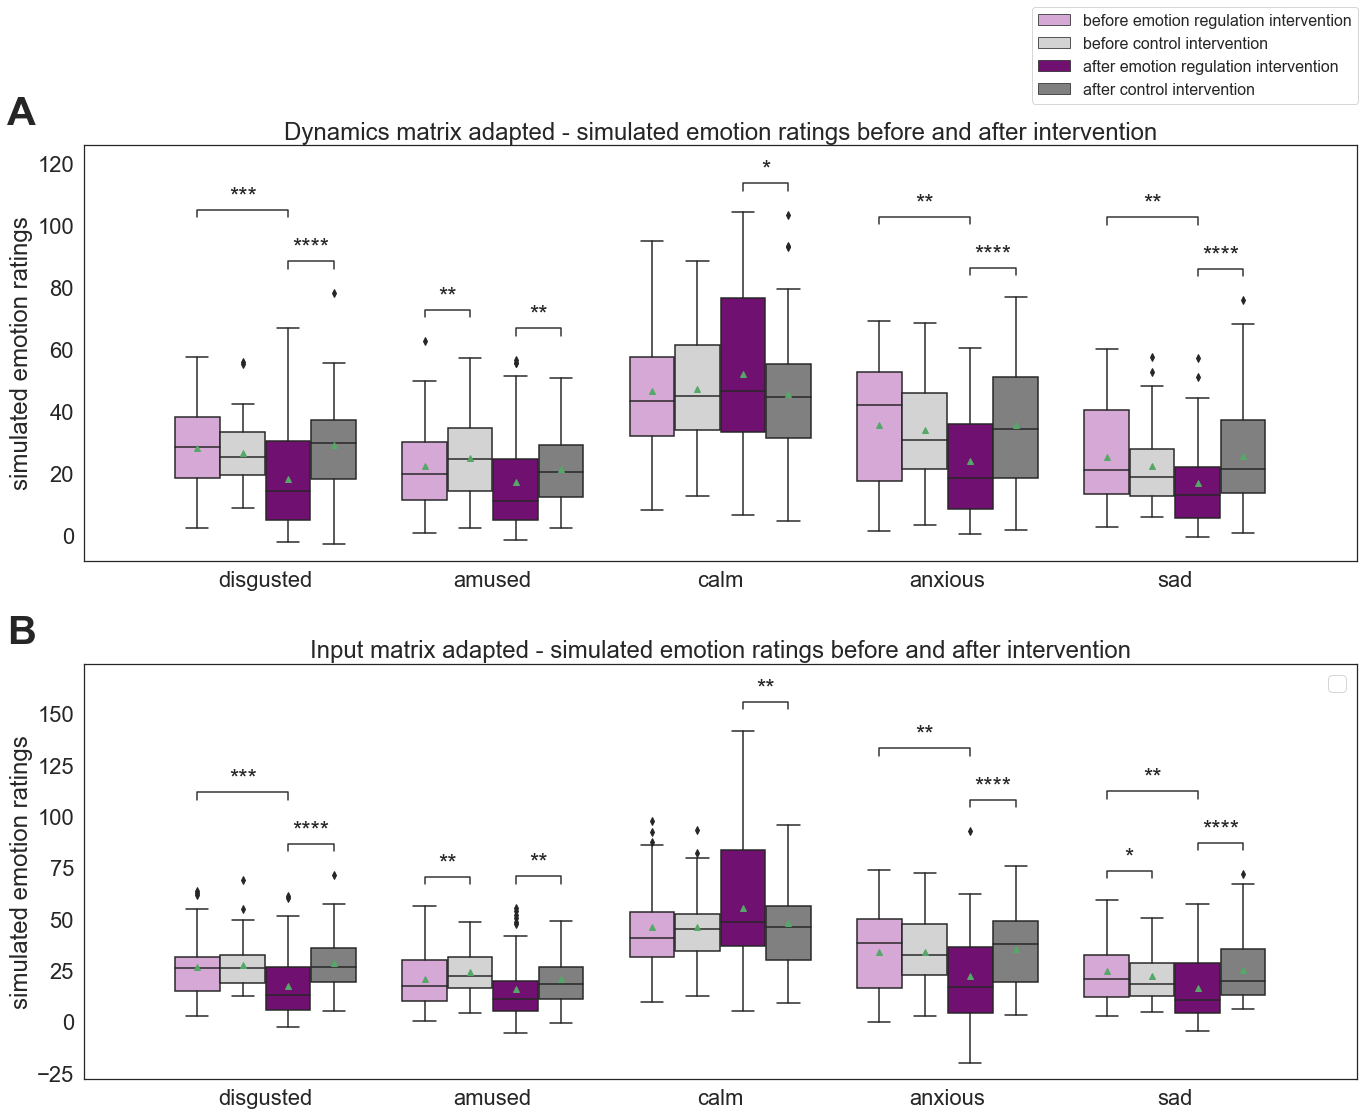

In [4]:
# Increase font size for the plot
sns.set(style='white', font_scale=2)

# Create a 3x1 grid of subplots for the three different simulations
fig, ax = plt.subplots(2, 1, figsize=(20, 16))

# Define labels for the simulations
label = ['Dynamics matrix adapted - simulated', 'Input matrix adapted - simulated', \
         'Dynamics and input matrix adapted - simulated']

# Initialize pairs for annotation
pairs = []
for i in mood_categories:
    for t in range(2):
        pairs.append([(i, t + (t * 1)), (i, t + (t * 1) + 1)])
        pairs.append([(i, 0 + t), (i, 2 + t)])

# Loop through the three different Kalman filter combinations
for i, kf_combinations in enumerate([[1, 2], [3, 4]]):

    # Simulate data using the given Kalman filter combinations
    mood_ratings_split = simulate_data(data, kf_combinations[0], kf_combinations[1], inp, mood_ratings)

    # Exclude outliers from the data
    foo, ex = emostats.exclude_outliers(data, kf_combinations[0], kf_combinations[1], 'results_split')

    # Prepare data for plotting
    df_plot = emostats.make_df(np.nanmean(mood_ratings_split[:, :, ~ex, :], axis=0), df[~ex], mood_categories)

    # Perform statistical tests and get p-values
    foo, pvalues = emostats.four_way_statistics(np.nanmean(mood_ratings_split[:, :, ~ex, :], axis=0), df[~ex])

    # Plot group differences for the current simulation
    emostats.plot_group_difference(df=df_plot, data_labels=mood_categories, \
                                   data_name=label[i] + ' ratings', pairs=pairs, fig=fig, ax=ax[i], \
                                   ms=False, show_ns=False, pvalues=pvalues, \
                                   show_legend=[True, False, False][i], legend_loc=(0.745, 1.1))

    # Set labels and title for the current subplot
    ax[i].set(ylabel='simulated emotion ratings', xlabel='', \
              title=label[i] + ' emotion ratings before and after intervention')
    ax[i].text(-0.06, 1.05, ['A', 'B', 'C'][i], transform=ax[i].transAxes, weight='bold', size=40);

    # Calculate group statistics
    df_stats_both = pd.DataFrame()
    for statistics in [np.nanmean(mood_ratings_split[:, :, ~ex, :], axis=0), \
                       np.nanvar(mood_ratings_split[:, :, ~ex, :], axis=0)]:
        df_stats, pvalues, tvalues = emostats.stats_group_difference(statistics, df[~ex])
        df_stats_both = pd.concat((df_stats_both, df_stats), axis=1)
    display(df_stats_both)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('../results/figures/simulations_replicating_distancing_effect.svg', bbox_inches='tight')

,T2,Fstats,pvalue,T2,Fstats,pvalue
before intervention,3.92,0.75,0.588,22.81,4.36,0.001
after intervention,12.39,2.37,0.046,16.08,3.07,0.013
change (after - before),47.24,9.03,< 0.001,3.31,0.63,0.676


,T2,Fstats,pvalue,T2,Fstats,pvalue
before intervention,9.50,1.82,0.115,13.87,2.66,0.027
after intervention,17.01,3.27,0.009,24.77,4.76,< 0.001
change (after - before),39.62,7.61,< 0.001,14.69,2.82,0.02


,T2,Fstats,pvalue,T2,Fstats,pvalue
before intervention,5.31,1.02,0.41,6.80,1.31,0.267
after intervention,19.87,3.82,0.003,35.53,6.83,< 0.001
change (after - before),39.34,7.56,< 0.001,17.20,3.31,0.008


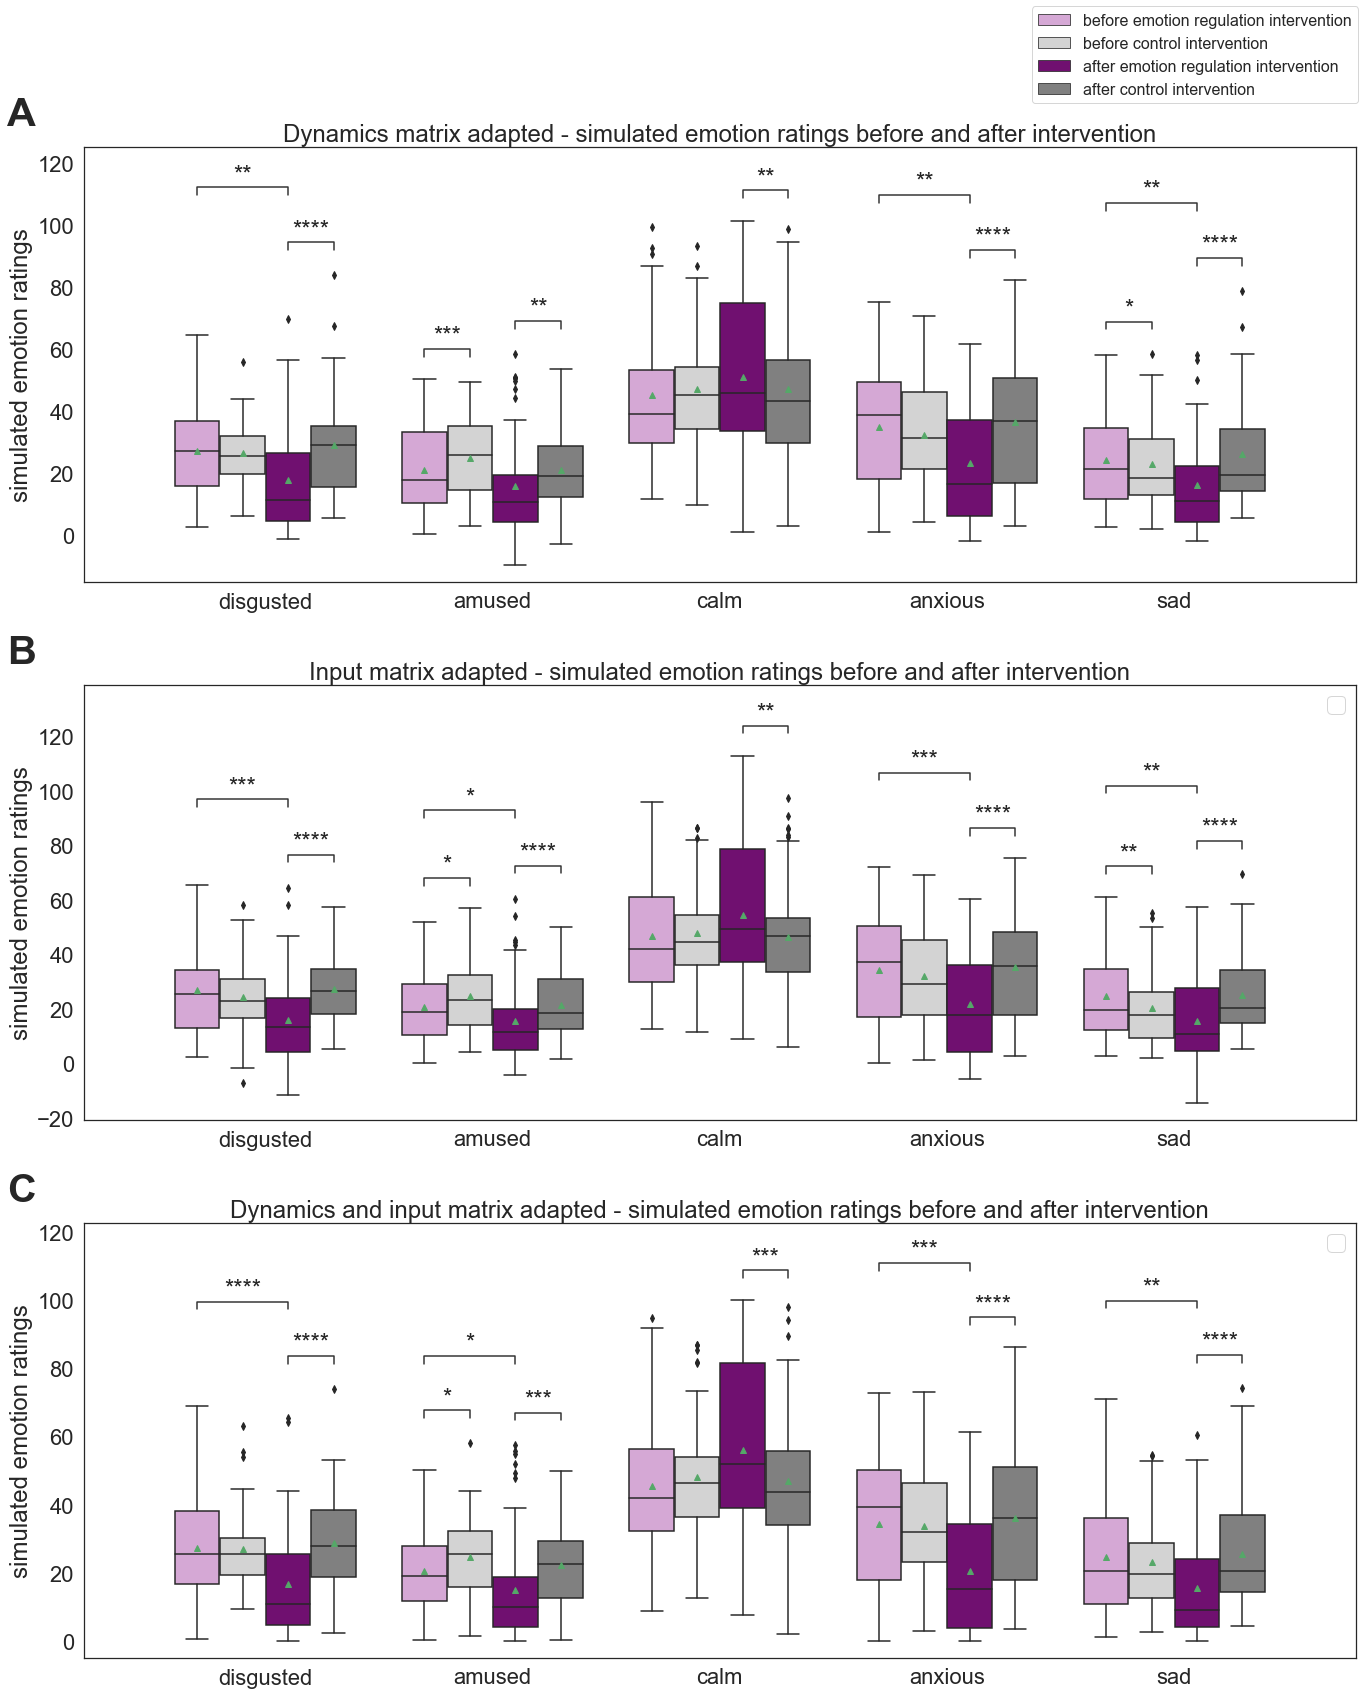

In [5]:
# Increase font size for the plot
sns.set(style='white', font_scale=2)

# Create a 3x1 grid of subplots for the three different simulations
fig, ax = plt.subplots(3, 1, figsize=(20, 24))

# Define labels for the simulations
label = ['Dynamics matrix adapted - simulated', 'Input matrix adapted - simulated', \
         'Dynamics and input matrix adapted - simulated']

# Initialize pairs for annotation
pairs = []
for i in mood_categories:
    for t in range(2):
        pairs.append([(i, t + (t * 1)), (i, t + (t * 1) + 1)])
        pairs.append([(i, 0 + t), (i, 2 + t)])

# Loop through the three different Kalman filter combinations
for i, kf_combinations in enumerate([[1, 2], [3, 4], [13, 14]]):

    # Simulate data using the given Kalman filter combinations
    mood_ratings_split = simulate_data(data, kf_combinations[0], kf_combinations[1], inp, mood_ratings)

    # Exclude outliers from the data
    foo, ex = emostats.exclude_outliers(data, kf_combinations[0], kf_combinations[1], 'results_split')

    # Prepare data for plotting
    df_plot = emostats.make_df(np.nanmean(mood_ratings_split[:, :, ~ex, :], axis=0), df[~ex], mood_categories)

    # Perform statistical tests and get p-values
    foo, pvalues = emostats.four_way_statistics(np.nanmean(mood_ratings_split[:, :, ~ex, :], axis=0), df[~ex])

    # Plot group differences for the current simulation
    emostats.plot_group_difference(df=df_plot, data_labels=mood_categories, \
                                   data_name=label[i] + ' ratings', pairs=pairs, fig=fig, ax=ax[i], \
                                   ms=False, show_ns=False, pvalues=pvalues, \
                                   show_legend=[True, False, False][i], legend_loc=(0.745, 1.1))

    # Set labels and title for the current subplot
    ax[i].set(ylabel='simulated emotion ratings', xlabel='', \
              title=label[i] + ' emotion ratings before and after intervention')
    ax[i].text(-0.06, 1.05, ['A', 'B', 'C'][i], transform=ax[i].transAxes, weight='bold', size=40);

    # Calculate group statistics
    df_stats_both = pd.DataFrame()
    for statistics in [np.nanmean(mood_ratings_split[:, :, ~ex, :], axis=0), \
                       np.nanvar(mood_ratings_split[:, :, ~ex, :], axis=0)]:
        df_stats, pvalues, tvalues = emostats.stats_group_difference(statistics, df[~ex])
        df_stats_both = pd.concat((df_stats_both, df_stats), axis=1)
    display(df_stats_both)

# Adjust layout and save the figure
plt.tight_layout()

In [6]:
def stats_T2(data, df):
    emostats.TwoSampleT2Test(np.nanmean(data[df['randomized_condition']==1,1], axis=0).T, \
                           np.nanmean(data[df['randomized_condition']==1,0], axis=0).T)

    
stats_mean, stats_var = np.zeros([3,100,2,3]), np.zeros([3,100,2,3])
# Loop through the three different Kalman filter combinations
for i, kf_combinations in enumerate([[1, 2], [3, 4], [13, 14]]):
    for r in range(100):
        # Simulate data using the given Kalman filter combinations
        mood_ratings_split = simulate_data(data, kf_combinations[0], kf_combinations[1], inp, mood_ratings)

        # Exclude outliers from the data
        foo, ex = emostats.exclude_outliers(data, kf_combinations[0], kf_combinations[1], 'results_split')
        
        # Calculate group statistics
        for j in range(2):
            stats_mean[i,r,j,:] = emostats.TwoSampleT2Test(np.nanmean(mood_ratings_split[:, :, \
                                                                   (~ex)&(df['randomized_condition']==1), j], axis=0).T, \
                           np.nanmean(mood_ratings_split[:, :, \
                                                         (~ex)&(df['randomized_condition']==0), j], axis=0).T)
        
            stats_var[i,r,j,:] = emostats.TwoSampleT2Test(np.nanvar(mood_ratings_split[:, :, \
                                                                       (~ex)&(df['randomized_condition']==1), j], axis=0).T, \
                               np.nanvar(mood_ratings_split[:, :, \
                                                             (~ex)&(df['randomized_condition']==0), j], axis=0).T)

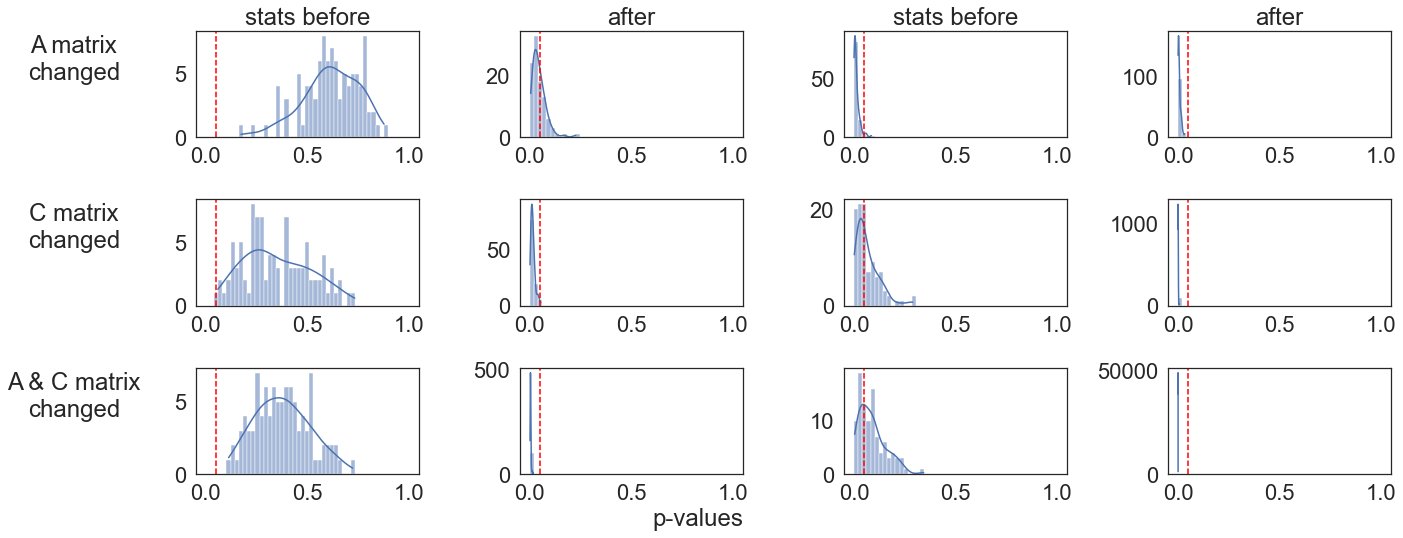

In [7]:
fig,ax = plt.subplots(3,4,figsize=(20,8))
for k, n in enumerate([stats_mean, stats_var]):
    for i in range(3): # different models
        for j in range(2): # stats before, after, change
            sns.histplot(data=n[i,:,j,2], kde=True, bins=np.linspace(0,1,50), ax=ax[i,j+k*2])
            if j == 0 and k == 0: ax[i,j+k*2].set_ylabel(['A matrix\nchanged',\
                                                          'C matrix\nchanged',\
                                                          'A & C matrix\nchanged'][i], \
                                                         rotation=0, labelpad=100, loc='center')
            else: ax[i,j+k*2].set(ylabel='')
            ax[i,j+k*2].axvline(0.05, color='red', linestyle='--')
            if i == 0: ax[i,j+k*2].set_title(['stats before', 'after', 'change'][j])    
            if j == 1 and k == 0 and i == 2: ax[i,j+k*2].set_xlabel('p-values', loc='right')
plt.tight_layout()